In [ ]:
import pandas as pd
from sqlalchemy import create_engine

server = 'DESKTOP-2VMSENQ'  
database = 'Northwind'
driver = 'ODBC Driver 17 for SQL Server'

connection_string = f"mssql+pyodbc://{server}/{database}?driver={driver.replace(' ', '+')}"

engine = create_engine(connection_string)

query = query = """
SELECT 
    o.OrderID,
    o.OrderDate,
    YEAR(o.OrderDate) AS OrderYear,
    MONTH(o.OrderDate) AS OrderMonth,
    DATENAME(WEEKDAY, o.OrderDate) AS OrderDayName,
    DATEDIFF(DAY, o.OrderDate, GETDATE()) AS DaysSinceOrder,
    c.CustomerID,
    c.CompanyName AS Customer,
    c.Country,
    e.EmployeeID,
    e.FirstName + ' ' + e.LastName AS Employee,
    p.ProductID,
    p.ProductName,
    p.CategoryID,
    p.UnitPrice AS ProductUnitPrice,
    p.UnitsInStock,
    p.UnitsOnOrder,
    od.Quantity,
    od.UnitPrice AS OrderUnitPrice,
    od.Quantity * od.UnitPrice AS Total

FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
JOIN Customers c ON o.CustomerID = c.CustomerID
JOIN Employees e ON o.EmployeeID = e.EmployeeID
JOIN Products p ON od.ProductID = p.ProductID;
"""
df = pd.read_sql_query(query, engine)
print(df.head())


   OrderID  OrderDate  OrderYear  OrderMonth OrderDayName  DaysSinceOrder  \
0    10248 1996-07-04       1996           7     Thursday           10615   
1    10248 1996-07-04       1996           7     Thursday           10615   
2    10248 1996-07-04       1996           7     Thursday           10615   
3    10249 1996-07-05       1996           7       Friday           10614   
4    10249 1996-07-05       1996           7       Friday           10614   

  CustomerID                   Customer  Country  EmployeeID         Employee  \
0      VINET  Vins et alcools Chevalier   France           5  Steven Buchanan   
1      VINET  Vins et alcools Chevalier   France           5  Steven Buchanan   
2      VINET  Vins et alcools Chevalier   France           5  Steven Buchanan   
3      TOMSP         Toms Spezialitäten  Germany           6   Michael Suyama   
4      TOMSP         Toms Spezialitäten  Germany           6   Michael Suyama   

   ProductID                    ProductName  Categ

In [2]:
print(df.shape)

(2155, 20)


In [5]:
print(df.describe())

            OrderID                      OrderDate    OrderYear   OrderMonth  \
count   2155.000000                           2155  2155.000000  2155.000000   
mean   10659.375870  1997-08-05 06:12:11.693735424  1997.132715     6.059397   
min    10248.000000            1996-07-04 00:00:00  1996.000000     1.000000   
25%    10451.000000            1997-02-19 00:00:00  1997.000000     3.000000   
50%    10657.000000            1997-09-04 00:00:00  1997.000000     5.000000   
75%    10862.500000            1998-01-31 12:00:00  1998.000000     9.000000   
max    11077.000000            1998-05-06 00:00:00  1998.000000    12.000000   
std      241.378032                            NaN     0.700856     3.637624   

       DaysSinceOrder   EmployeeID    ProductID   CategoryID  \
count     2155.000000  2155.000000  2155.000000  2155.000000   
mean     10217.741531     4.333179    40.793039     4.135499   
min       9944.000000     1.000000     1.000000     1.000000   
25%      10038.500000  

In [6]:
print(df.shape)
print(df.isnull().sum())

(2155, 20)
OrderID             0
OrderDate           0
OrderYear           0
OrderMonth          0
OrderDayName        0
DaysSinceOrder      0
CustomerID          0
Customer            0
Country             0
EmployeeID          0
Employee            0
ProductID           0
ProductName         0
CategoryID          0
ProductUnitPrice    0
UnitsInStock        0
UnitsOnOrder        0
Quantity            0
OrderUnitPrice      0
Total               0
dtype: int64


In [18]:
query = """
SELECT TOP 10 
    p.ProductName,
    SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM [Order Details] od
JOIN Products p ON od.ProductID = p.ProductID
GROUP BY p.ProductName
ORDER BY TotalSales DESC;
"""

df_top_products = pd.read_sql_query(query, engine)
print(df_top_products)

               ProductName  TotalSales
0            Côte de Blaye    149984.2
1  Thüringer Rostbratwurst     87736.4
2     Raclette Courdavault     76296.0
3        Camembert Pierrot     50286.0
4           Tarte au sucre     49827.9
5   Gnocchi di nonna Alice     45121.2
6    Manjimup Dried Apples     44742.6
7             Alice Mutton     35482.2
8         Carnarvon Tigers     31987.5
9        Rössle Sauerkraut     26865.6


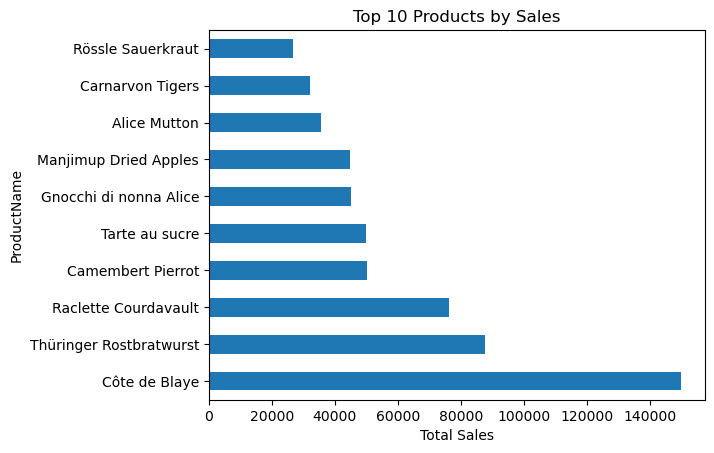

In [11]:
import matplotlib.pyplot as plt

top_products = df.groupby("ProductName")["Total"].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', title='Top 10 Products by Sales')
plt.xlabel('Total Sales')
plt.show()

In [19]:
query = """
SELECT 
    e.FirstName + ' ' + e.LastName AS Employee,
    SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
JOIN Employees e ON o.EmployeeID = e.EmployeeID
GROUP BY e.FirstName, e.LastName
ORDER BY TotalSales DESC;
"""

df_sales_by_employee = pd.read_sql_query(query, engine)
print(df_sales_by_employee)


           Employee  TotalSales
0  Margaret Peacock   250187.45
1   Janet Leverling   213051.30
2     Nancy Davolio   202143.71
3     Andrew Fuller   177749.26
4       Robert King   141295.99
5    Laura Callahan   133301.03
6    Anne Dodsworth    82964.00
7    Michael Suyama    78198.10
8   Steven Buchanan    75567.75


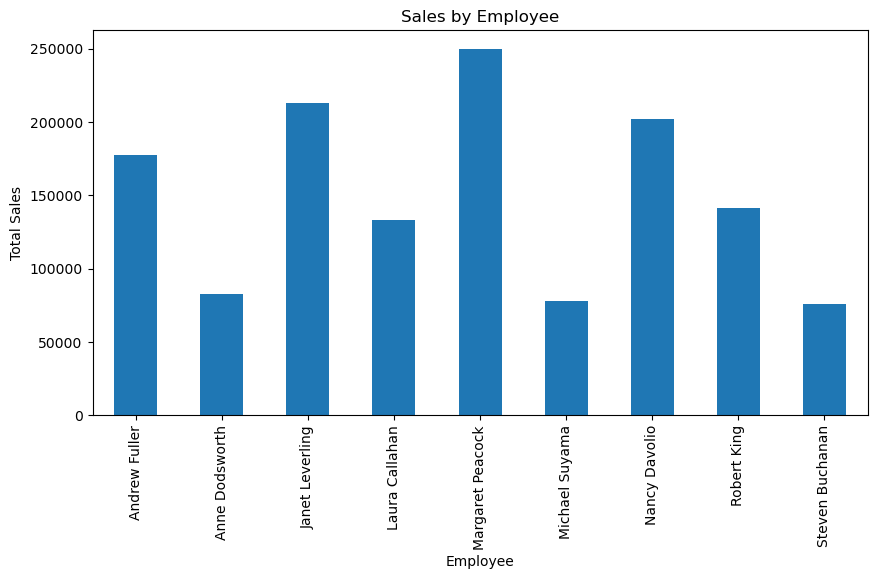

In [12]:
df.groupby("Employee")["Total"].sum().plot(kind='bar', title='Sales by Employee', figsize=(10,5))
plt.ylabel('Total Sales')
plt.show()

In [20]:
query = """
SELECT 
    FORMAT(o.OrderDate, 'yyyy-MM') AS OrderMonth,
    SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
GROUP BY FORMAT(o.OrderDate, 'yyyy-MM')
ORDER BY OrderMonth;
"""

monthly_df = pd.read_sql_query(query, engine)
print(monthly_df)


   OrderMonth  TotalSales
0     1996-07    30192.10
1     1996-08    26609.40
2     1996-09    27636.00
3     1996-10    41203.60
4     1996-11    49704.00
5     1996-12    50953.40
6     1997-01    66692.80
7     1997-02    41207.20
8     1997-03    39979.90
9     1997-04    55699.39
10    1997-05    56823.70
11    1997-06    39088.00
12    1997-07    55464.93
13    1997-08    49981.69
14    1997-09    59733.02
15    1997-10    70328.50
16    1997-11    45913.36
17    1997-12    77476.26
18    1998-01   100854.72
19    1998-02   104561.95
20    1998-03   109825.45
21    1998-04   134630.56
22    1998-05    19898.66


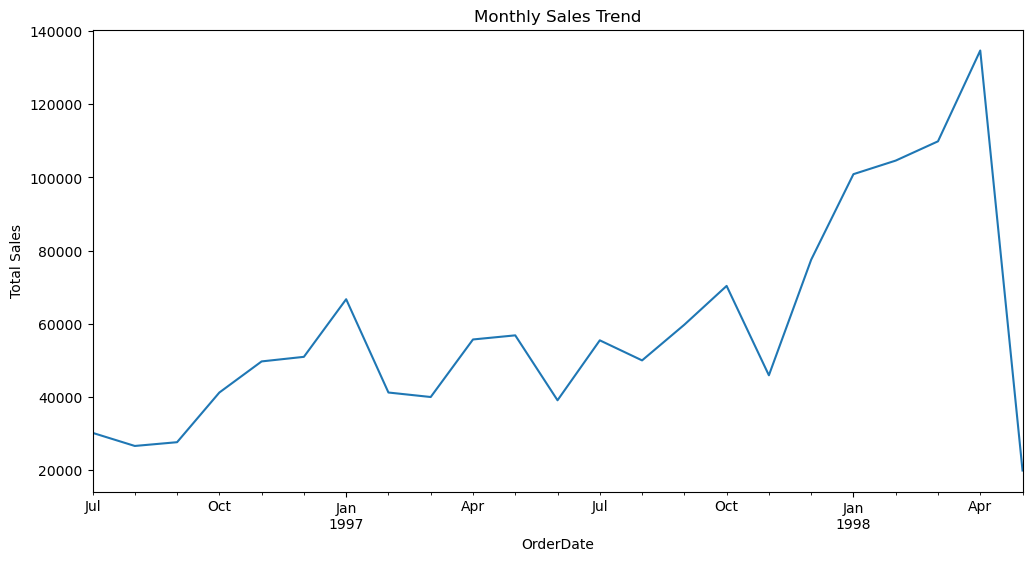

In [13]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df.groupby(df['OrderDate'].dt.to_period('M'))['Total'].sum().plot(title='Monthly Sales Trend', figsize=(12,6))
plt.ylabel('Total Sales')
plt.show()

In [21]:
query = """
SELECT 
    c.Country,
    SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
JOIN Customers c ON o.CustomerID = c.CustomerID
GROUP BY c.Country
ORDER BY TotalSales DESC;
"""

top_countries_df = pd.read_sql_query(query, engine)

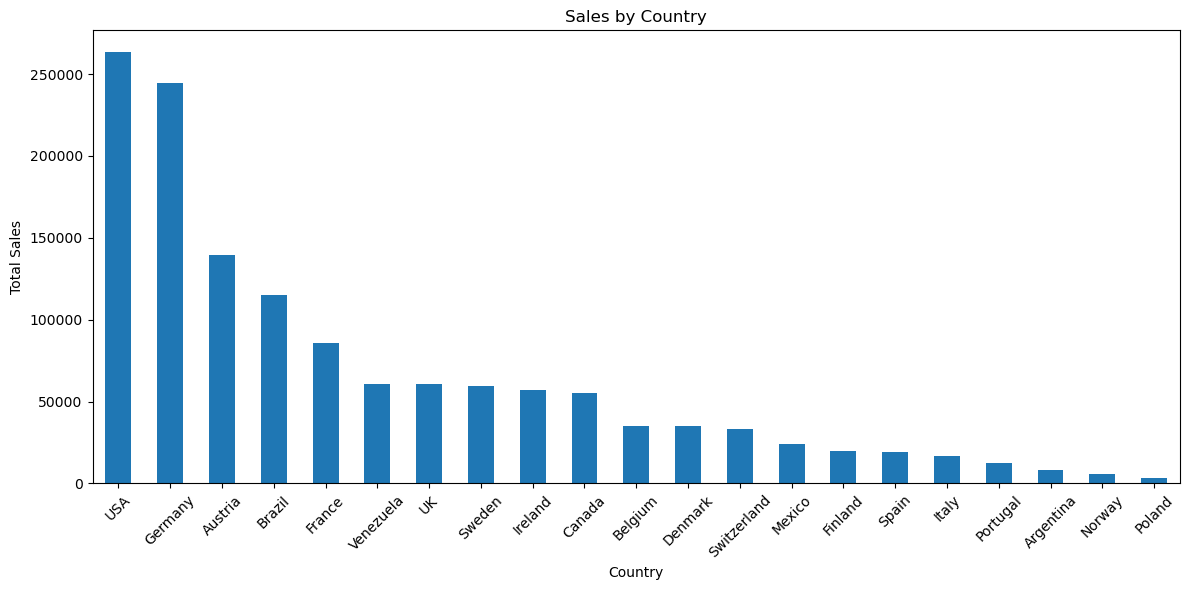

In [14]:
top_countries = df.groupby("Country")["Total"].sum().sort_values(ascending=False)

top_countries.plot(kind='bar', figsize=(12,6), title='Sales by Country', ylabel='Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
query = """
SELECT TOP 5
    c.CompanyName AS Customer,
    SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
JOIN Customers c ON o.CustomerID = c.CustomerID
GROUP BY c.CompanyName
ORDER BY TotalSales DESC;
"""
top_customers_df = pd.read_sql_query(query, engine)

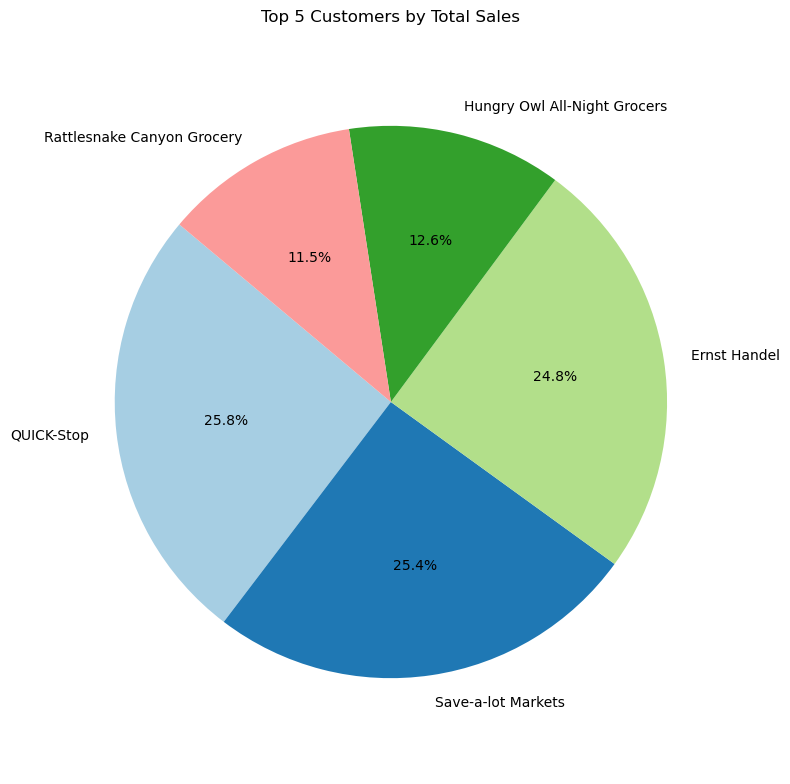

In [17]:
top_customers = df.groupby("Customer")["Total"].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(8,8))
plt.pie(
    top_customers,
    labels=top_customers.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title('Top 5 Customers by Total Sales')
plt.axis('equal') 
plt.tight_layout()
plt.show()


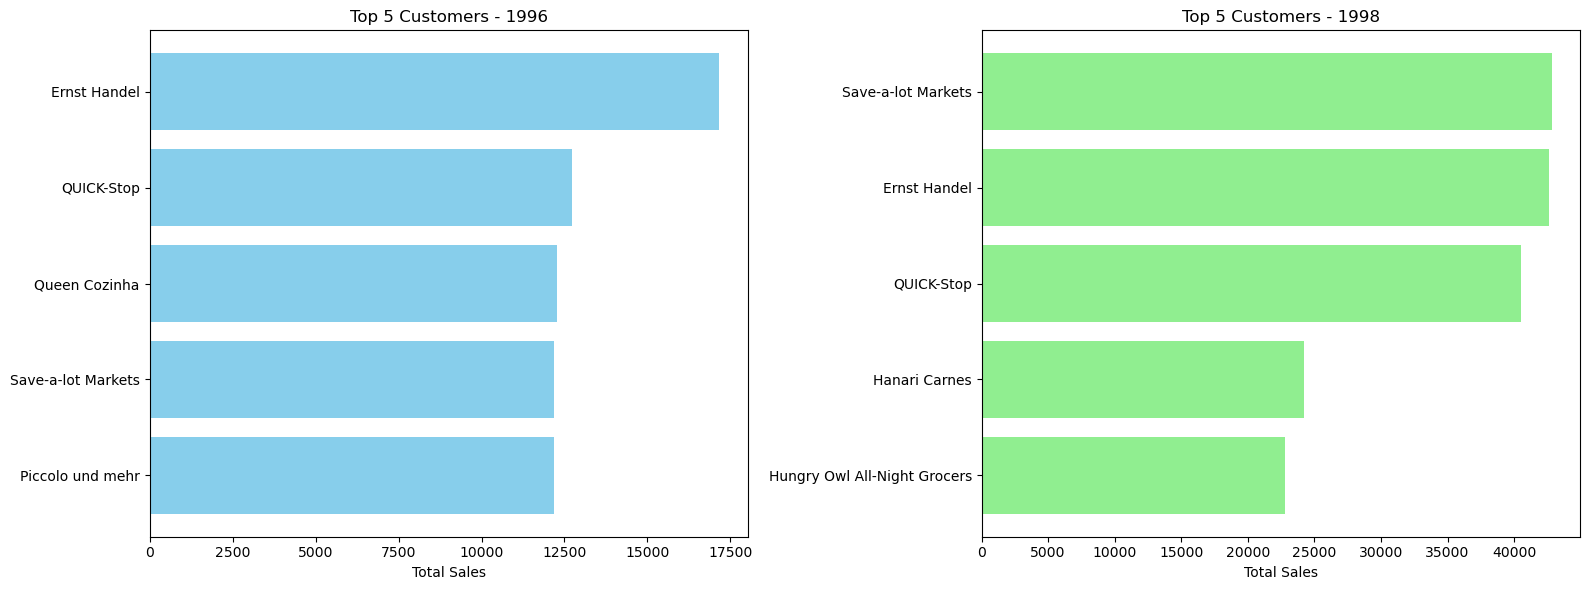

In [27]:
query = """
SELECT 
    c.CompanyName AS Customer,
    YEAR(o.OrderDate) AS OrderYear,
    SUM(od.UnitPrice * od.Quantity) AS TotalSales
FROM Orders o
JOIN [Order Details] od ON o.OrderID = od.OrderID
JOIN Customers c ON o.CustomerID = c.CustomerID
WHERE YEAR(o.OrderDate) IN (1996, 1998)
GROUP BY c.CompanyName, YEAR(o.OrderDate)
"""

df_customers = pd.read_sql_query(query, engine)
top_1996 = df_customers[df_customers["OrderYear"] == 1996].sort_values("TotalSales", ascending=False).head(5)
top_1998 = df_customers[df_customers["OrderYear"] == 1998].sort_values("TotalSales", ascending=False).head(5)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(top_1996["Customer"], top_1996["TotalSales"], color='skyblue')
axes[0].set_title("Top 5 Customers - 1996")
axes[0].set_xlabel("Total Sales")
axes[0].invert_yaxis()

axes[1].barh(top_1998["Customer"], top_1998["TotalSales"], color='lightgreen')
axes[1].set_title("Top 5 Customers - 1998")
axes[1].set_xlabel("Total Sales")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
